# Histopathologic Cancer Detection - [Kaggle competiton](https://www.kaggle.com/competitions/histopathologic-cancer-detection)

The goal of this Kaggle competition is to develop a model that detects the presence of metastatic cancer within microscope images of stained lymph node tissue samples.  This competition is a binary image classifiction task that uses a modified version of the [PatchCamelyon dataset](https://github.com/basveeling/pcam).

The training dataset contains 220,025 labeled training images. The test set contains 57,458 unlabeled images.  All images are 96x96 pixels with RGB color values. They are stored in the .tif image format.

Samples with micrometastases or macrometastases inside the central 32x32 pixel region of the image should be labeled _positive_.  Samples with no metastatic cancer cells inside the central 32x32 pixel region should be labeled _negative_, even if another region of the image contains a tumor.  Note: isolated tumor cells should be ignored. 

*Note: to improve the readability of this notebook, models were trained and saved (along with training histories) by a separate notebook.  This model training notebook can be found [here](https://colab.research.google.com/drive/1d4JRIKAvV6gwDOE5xanHy699mg46kdhB?usp=sharing), and can be used to train and save the models that are referenced in this report.*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# download dataset from kaggle.  file size > 6 GB
import os
os.environ['KAGGLE_USERNAME'] = "KAGGLE_USERNAME" # insert kaggle login info here if you wish to run this notebook
os.environ['KAGGLE_KEY'] = "KAGGLE_KEY" # insert kaggle login info here if you wish to run this notebook
!kaggle competitions download -c histopathologic-cancer-detection
! mkdir input # create destination for unzipping data
! unzip /content/histopathologic-cancer-detection.zip -d input

In [ ]:
# Google Colab paths
TRAIN_DIR = "/content/input/train/"
TEST_DIR = "/content/input/test/"
label_path = "/content/input/train_labels.csv"
model_path = "/content/gdrive/MyDrive/!Data/kaggle_cancer/models/"

In [ ]:
%%capture  
!pip install ktrain

In [ ]:
import ktrain
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image  import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.layers import CenterCrop, InputLayer
import ktrain

%matplotlib inline

---
# EDA

The dataset shouldn't need any cleaning because the images are already stored in a consistent format and defective images were removed from the original dataset before publication.  

However, there is no guarantee that this competition has provided balanced training data, so we should verify that the training set is balanced before proceeding.


In [ ]:
df_train = pd.read_csv(label_path)
# add file extension to file names
df_train["id"] = df_train["id"]+".tif"
# convert labels into strings for compatibility with keras ImageDataGenerator
df_train["label"] = df_train["label"].astype(str)
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


0    0.594969
1    0.405031
Name: label, dtype: float64


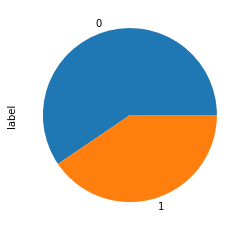

In [ ]:
# check frequencies of labels to see if we'll need to balance them
print(df_train["label"].value_counts(normalize=True))
df_train["label"].value_counts().plot.pie()

The training set is imbalanced.  The 60-40 split between negative and positive classes isn't egregious, but it's still worth balancing.  

Oversampling and undersampling are equally valid options, but I'm going to undersample the negative class because we'll still have plenty of training images and oversampling would lengthen the time to train our models.   

In [ ]:
# balance the dataset through downsampling
pos_subset = df_train[df_train.label == "1"]
neg_subset = df_train[df_train.label == "0"].sample(n=pos_subset.shape[0], random_state=1)
df_train = pd.concat([pos_subset, neg_subset]).sample(frac=1, random_state=1).reset_index(drop=True)

print(pos_subset.shape)
print(neg_subset.shape)
print(df_train.shape)

(89117, 2)
(89117, 2)
(178234, 2)


A small sample of positive and negative images are shown below.  

Cancer cells usually have a different size and density than surrounding healthy tissue.  The difference between the larger tumor cells and the smaller healthy cells is particularly apparent in 3rd image of the top row.

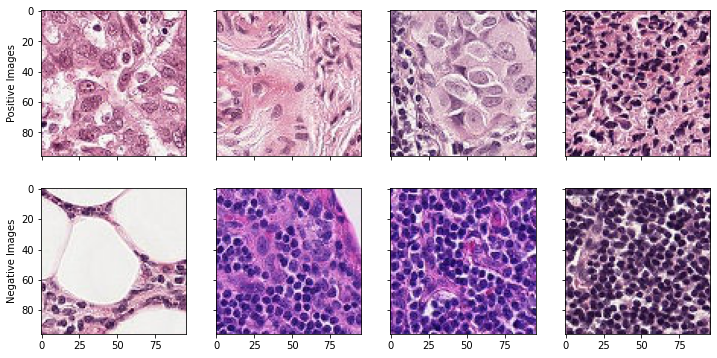

In [ ]:
# plot example images
fig, axs = plt.subplots(nrows=2,ncols=4, sharey="row", sharex="col", figsize=(12,6))
n_examples=4
# positive images
pos_imgs = df_train.loc[df_train["label"]=="1","id"].values.tolist()
for i in range(n_examples):
  img = imread(TRAIN_DIR+pos_imgs[i])
  axs[0,i].imshow(img)

# negative images
neg_imgs = df_train.loc[df_train["label"]=="0","id"].values.tolist()
for i in range(n_examples):
  img = imread(TRAIN_DIR+neg_imgs[i])
  axs[1,i].imshow(img)

fig.axes[0].set_ylabel("Positive Images")
fig.axes[4].set_ylabel("Negative Images")
plt.show()

I will augment the training dataset by randomly flipping the images horizontally and vertically to reduce overfitting.  The orientation of these images is aribitrary, so no information will be lost by these transformations. 

I will not perform other transformations such as rotating, shearing, or zooming the images, because that would _not_ preserve the central 32x32 pixel patch which the labels are based upon.

I will also rescale the pixel values from [0-255] to [0-1]

In [ ]:
batch_size = 64

img_data_generator = ImageDataGenerator(
    validation_split=0.2, 
    rescale=1/255, 
    horizontal_flip=True,
    vertical_flip=True)

train_data = img_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = TRAIN_DIR,
    x_col="id",
    y_col="label",
    class_mode="binary",
    target_size = (96,96),
    color_mode = "rgb",
    batch_size = batch_size,
    seed = 1,
    subset="training")

val_data = img_data_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = TRAIN_DIR,
    x_col="id",
    y_col="label",
    class_mode="binary",
    target_size = (96,96),
    color_mode = "rgb",
    batch_size = batch_size,
    seed = 1,
    subset="validation")

Found 142588 validated image filenames belonging to 2 classes.
Found 35646 validated image filenames belonging to 2 classes.


In [ ]:
# create a keras ImageDataGenerator for the Test images
test_files = os.listdir(TEST_DIR)
df_test = pd.DataFrame({"id":test_files})

test_img_data_generator = ImageDataGenerator(rescale=1/255)

test_data = test_img_data_generator.flow_from_dataframe(
    dataframe = df_test,
    x_col="id",
    directory = TEST_DIR,
    class_mode=None,
    target_size = (96,96),
    color_mode = "rgb",
    batch_size = 32,
    shuffle=False)

Found 57458 validated image filenames.


---
# Model Design

My CNN model is based upon the VGGnet architecture.  The image is fed into repeating sets of two 3x3 convolution layers followed by 2x2 MaxPooling.  When the feature map size is halved (by MaxPooling) we double the number of filters in future convolution layers.  Following the sets of convolutional layers are fully connected (FC) layers.  Batch normalization is performed before all ReLU activation layers.

Even with this overall architectural plan, specific details must be worked out regarding the number of convolution layers, size of input image (cropping), number of FC layers, and the use of dropout layers to mitigate overfitting.  Throwing together an enormously deep model would surely be successful for this (relatively) simple task, but my goal for this competition is to keep the model fairly simple while achieving reasonable validation accuracy ( >95% ). To achieve this, I will train simple models with various convolution layer options for 5 epochs and compare their performance.  I'll then compare several new models that use that configuration of convolution layers followed by different FC layer designs. 

I'll select the best performing model from these candidate models to fully train as my final model.  To save time, I will only consider hyperparameter tuning (learning rates) for that final model.

This methodology is _not_ guaranteed to yield the _best_ possible architecture, but it should guarantee that I select an adequate architecture without wasting time extensively training inadequate models.

__Note: the code that generated these saved models is available in a separate notebook in this github repo. It is in a separate notebook for the sake of readability.__



In [ ]:
#function to plot model training histories
def plot_history(df_history, title):
  fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
  ax[0].plot("epoch", "loss", data = df_history)
  ax[0].plot("epoch", "val_loss", data = df_history)
  fig.axes[0].set_ylabel('loss')
  fig.axes[0].set_xlabel('epoch')
  ax[0].legend(['train', 'val'], loc='upper left')

  ax[1].plot("epoch", "accuracy", data = df_history)
  ax[1].plot("epoch", "val_accuracy", data = df_history)
  fig.axes[1].set_ylabel('accuracy')
  fig.axes[1].set_xlabel('epoch')
  ax[1].legend(['train', 'val'], loc='upper left')

  fig.suptitle(title)
  plt.show()

# Convolution layer considerations

Each image in the dataset is 96x96 pixels, but the center 32x32 pixel patch is all that matters for the purposes of labeling.  I will experiment with different sized cropped images to determine whether the entire image is necessary.  If the model can perform with a cropped input, the model will need fewer calcultions, and will run faster.  I will try 3 models with different center cropping of the input image: 34x34 pixels, 64x64 pixels, and the raw image (no crop).  If all else is equal, I would prefer to keep the model that crops the image as small as possible.

The 34x34 pixel crop is probably too aggressive since it would have trouble detecting tumors that barely touch the 32x32 target region.  The 64x64 crop is likely to have a better chance of matching the performance of the model uses the raw image (no crop).  Note that the size of the crop has an effect on the model's number of trainable parameters (least cropping = most parameters).


## 34x34 cropped model
2.4M parameters

In [ ]:
# load saved model and show model summary
model_crop_34 = keras.models.load_model(model_path+"model_crop_34")
model_crop_34.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop (CenterCrop)    (None, 34, 34, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

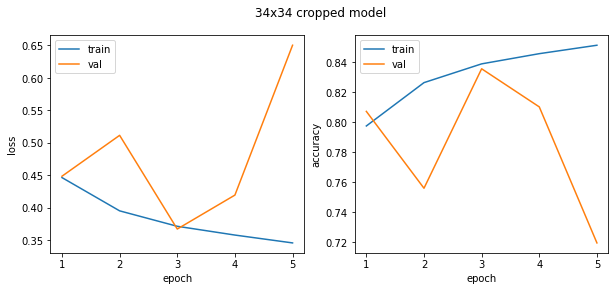

In [ ]:
# load model_crop_34's history from saved csv
hist_csv_file = model_path+'history_crop_34.csv'
df_history_crop_34 = pd.read_csv(hist_csv_file)
plot_history(df_history_crop_34, "34x34 cropped model")

The 34x34 appears to be a weak candidate, which is not surprising.  Despite the underwhelming training accuracy, there appears to be evidence of overfitting after the 3rd epoch.  

## 64x64 cropped model 
5.4M parameters

In [ ]:
# load saved model and show model summary
model_crop_64 = keras.models.load_model(model_path+"model_crop_64")
model_crop_64.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_1 (CenterCrop)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                      

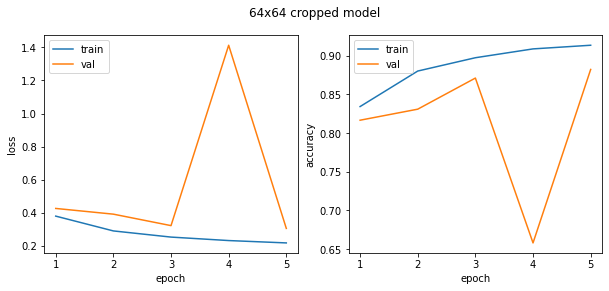

In [ ]:
#load model_crop_64's history from saved csv
hist_csv_file = model_path+'history_crop_64.csv'
df_history_crop_64 = pd.read_csv(hist_csv_file)
plot_history(df_history_crop_64, "64x64 cropped model")

The 64x64 cropped model looks promising if we consider the behavior at epoch 4 to be an aberration.  Aside from epoch 4, the training and validation accuracies look promising.

## uncropped "raw" model
10.6M parameters

In [ ]:
# load saved model and show model summary
model_raw = keras.models.load_model(model_path+"model_raw")
model_raw.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_15 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_16 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 96, 96, 64)       

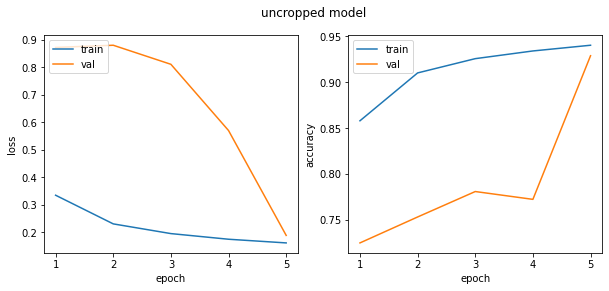

In [ ]:
#load model's history from saved csv
hist_csv_file = model_path+'history_raw.csv'
df_history_raw = pd.read_csv(hist_csv_file)
plot_history(df_history_raw, "uncropped model")

The uncropped "raw" model is promising, but perhaps deserving of suspicion.  The validation accuracy is poor until epoch 5, but it might indicate that the model could perform well with optimized learning rate and/or different FC layer configuration.

## Convolution layer comparison.

Both the 64x64 cropped model and the "raw" uncropped model show potential.  The 64x64 crop yielded reasonable performance relatively consistently, but the raw model had a great validation accuracy (0.92) by epoch 5.  Both of these models merit further consideration as we tweak FC layer configurations.

The 34x34 cropped model is not worth further consideration.

<function matplotlib.pyplot.show>

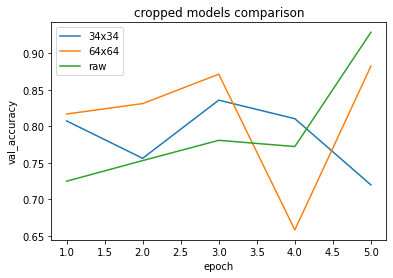

In [ ]:
#compare validation loss for all 3 models
plt.plot("epoch", "val_accuracy", data = df_history_crop_34)
plt.plot("epoch", "val_accuracy", data = df_history_crop_64)
plt.plot("epoch", "val_accuracy", data = df_history_raw)
plt.legend(['34x34', '64x64', 'raw'], loc='upper left')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.title("cropped models comparison")
plt.show


In [ ]:
# remove previous models from memory
keras.backend.clear_session()

# Fully connected (FC) layer considerations

So far, we have utilized a single 256-unit FC layer, but this was an arbitrary decision, and there is no reason to believe that it is optimal. 

We'll compare the single 256-unit FC layer to a 128-unit FC layer followed by a 64-unit FC layer.  We'll also compare the effect of dropout layers following those FC layers (since there was some evidence of overfitting)  

## Uncropped model
## 128 --> 64 FC layers
5.9M parameters

In [ ]:
# load saved model and show its summary
model_raw_2 = keras.models.load_model(model_path+"model_raw_2")
model_raw_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_23 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_26 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_24 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 96, 96, 64)       

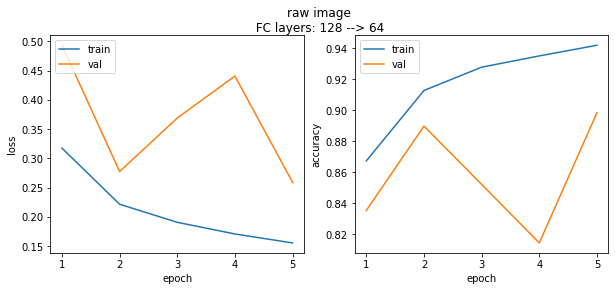

In [ ]:
#load model_raw_2's history from saved csv
hist_csv_file = model_path+'history_raw_2.csv'
df_history_raw_2 = pd.read_csv(hist_csv_file)
plot_history(df_history_raw_2, "raw image \n FC layers: 128 --> 64 ")

These results aren't particularly exciting since the validation accuracy is neither stellar nor stable.

## Uncropped model
## 128 --> 64 FC layers 
## Dropout layers
5.9M parameters

In [ ]:
#load saved model and show summary
model_raw_2_do = keras.models.load_model(model_path+"model_raw_2_do")
model_raw_2_do.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_41 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_46 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_42 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 activation_47 (Activation)  (None, 96, 96, 64)       

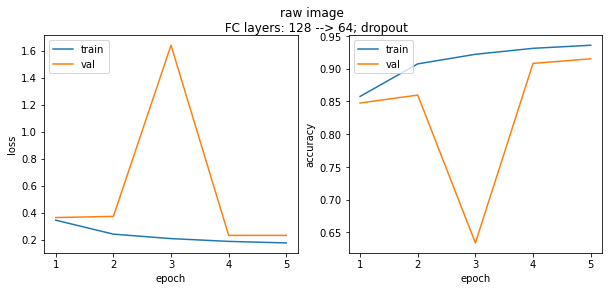

In [ ]:
#load model_raw_2_do's history from saved csv
hist_csv_file = model_path+'history_raw_2_do.csv'
df_history_raw_2_do = pd.read_csv(hist_csv_file)
plot_history(df_history_raw_2_do, "raw image \n FC layers: 128 --> 64; dropout")

This model seems promising.  If we ignore epoch 3, we have model that appears stable and has a fairly high validation accuracy.

Not bad considering that we have yet to optimize learning rates.

## 64x64 cropped model
## 128 --> 64 FC layers
3.3M parameters

In [ ]:
# load saved model and show summary
model_2_crop_64 = keras.models.load_model(model_path+"model_2_crop_64")
model_2_crop_64.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_2 (CenterCrop)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_32 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                     

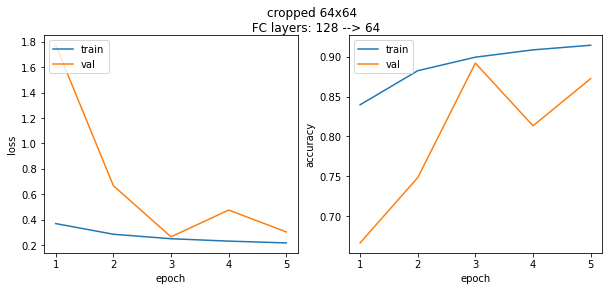

In [ ]:
#load model_crop_64's history from saved csv
hist_csv_file = model_path+'history_2_crop_64.csv'
df_history_2_crop_64 = pd.read_csv(hist_csv_file)
plot_history(df_history_2_crop_64, "cropped 64x64 \n FC layers: 128 --> 64")

This model appears to be a poor choice compared to our other options.  We have models that are more stable and more accurate than this one.  

## 64x64 cropped model
## 128 --> 64 FC layers
## Dropout layers
3.3M parameters

In [ ]:
# load saved model
model_2_crop_64_do = keras.models.load_model(model_path+"model_2_crop_64_do")
model_2_crop_64_do.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_3 (CenterCrop)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_50 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 activation_56 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_51 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                     

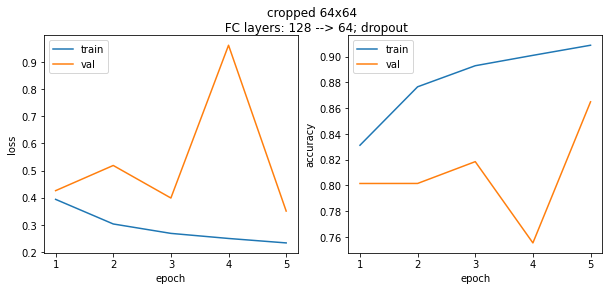

In [ ]:
#load model_2_crop_64_do's history from saved csv
hist_csv_file = model_path+'history_2_crop_64_do.csv'
df_history_2_crop_64_do = pd.read_csv(hist_csv_file)
plot_history(df_history_2_crop_64_do, "cropped 64x64 \n FC layers: 128 --> 64; dropout")

Another comparatively weak model. Worse accuracy and less stable than our better options. 

# FC layer comparison

The most promising model is the model with no image cropping, 2 FC layers (128,64), and dropout layers.  This model had slightly lower validation accuracy (0.91) at epoch five than another model, but was significantly more consistent.

Overall, I feel confident that this model architecture will yield acceptable performance after it has been fully trained with an optimal learning rate.

Sidenote: at epoch 5, the 3 uncropped variations all outperformed the 3 cropped variations.


<function matplotlib.pyplot.show>

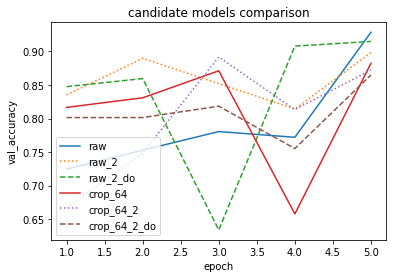

In [ ]:
#compare validation loss for 6 candidate models

plt.plot("epoch", "val_accuracy", data = df_history_raw)
plt.plot("epoch", "val_accuracy", ":", data = df_history_raw_2)
plt.plot("epoch", "val_accuracy", "--", data = df_history_raw_2_do)
plt.plot("epoch", "val_accuracy", data = df_history_crop_64)
plt.plot("epoch", "val_accuracy", ":", data = df_history_2_crop_64)
plt.plot("epoch", "val_accuracy", "--", data = df_history_2_crop_64_do)
plt.legend(['raw', 'raw_2', "raw_2_do", 'crop_64', 'crop_64_2', 'crop_64_2_do' ], loc='lower left')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.title("candidate models comparison")
plt.show

In [ ]:
# remove previous models from memory
keras.backend.clear_session()

---
# Hyperparameter tuning

Before we fully train our final model, we need to carefully consider our learning rate strategy.  An optimal learning rate will speed up the training process and help improve the model's accuracy.

I will use a cyclical learning rate, specifically, a triangular learning rate policy that linearly changes the learning rate between an upper and lower bound. 

An "LR range test" can be used to find a reasonable maximum learning rate. The LR range test involves training the model for a couple epochs while linearly changing from a very low to very high learning rate.  After running the LR range test, a plot of accuracy vs. learning rate can be used to find the largest reasonable learning rate.  More details about cyclical learning rates and LR range tests can be found [in this paper](https://arxiv.org/pdf/1506.01186.pdf)

The [ktrain](https://github.com/amaiya/ktrain) python package is a keras wrapper that provides an LR range test and cyclical learning rate implementation.

In [ ]:
# load model from saved file
final_model = keras.models.load_model(model_path+'final_model/tf_model.h5')
final_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_59 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_66 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_60 (Bat  (None, 96, 96, 64)       256       
 chNormalization)                                                
                                                                 
 activation_67 (Activation)  (None, 96, 96, 64)       

In [ ]:
learner = ktrain.get_learner(
    model=final_model,
    train_data=train_data,
    val_data=val_data,
    workers=8,
    batch_size=32
)

In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
4455/4455 [==============================] - 106s 23ms/step - loss: 0.9564 - accuracy: 0.6688


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


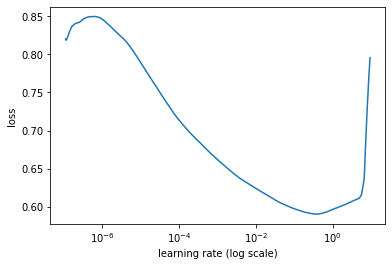

In [ ]:
learner.lr_plot()

Maximum learning rate should be chosen from this plot.  We want to select a learning rate with low loss _before_ the loss begins increasing again.  

Based on this plot, 1e-1 is a reasonable choice.

## Final model training details

The model will be trained for a maximum of 40 epochs. If the validation loss doesn't improve for 5 epochs, the model training will stop early.

I will use a triangular learning rate policy with an initial max LR of 0.1. Max LR will be halved whenever the validation loss doesn't improve for 3 epochs.

At the end of training, the model weights will be reloaded from the epoch with the smallest validation loss

In [ ]:
final_history = learner.autofit(
    lr=1e-1,
    epochs = 40,
    early_stopping=5,
    reduce_on_plateau=3
)

# Results

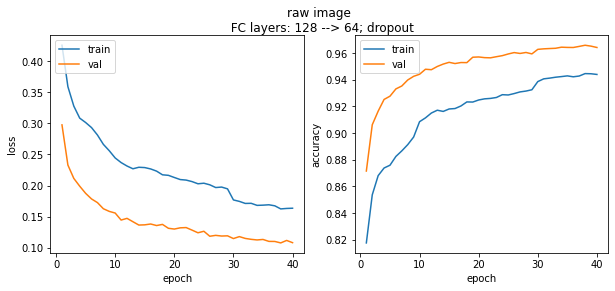

In [ ]:
#load final_model's history from saved csv
hist_csv_file = model_path+'final_history.csv'
df_final_history = pd.read_csv(hist_csv_file)
plot_history(df_final_history, "raw image \n FC layers: 128 --> 64; dropout")

This training history looks great! The validation accuracy exceeds 0.96 and is fairly stable.

At first glance, it might seem confusing that the training accuracy is _lower_ than the validation accuracy, but this is attributable to the dropout layers.  During training, half of the units in each FC layer are disabled, but all units are enabled for the validation set.

Note the steep drop in training loss between epochs 28 and 29.  This is due to the maximum learning rate dropping in half (triggered by the `reduce_on_plateau` callback) when the validation loss stagnated.

<h3 align="center">Candidate model summary</h3> 


| cropping | FC Layer units |  best val_accuracy by epoch 5 | 
|---|---|---|
|34x34 |  256 | 0.84      |
|64x64 |  256 |  0.88     |
|64x64 | (128,64)    |   0.89    |
|64x64 | (128,64) Dropout|   0.86    |
|uncropped |  256 |  0.93      |
|uncropped |  (128,64) |  0.90   |
|uncropped | (128,64) Dropout |   0.92     |
|  |  |  |
|uncropped (final_model) | (128,64) Dropout | 0.93 |


## Test Predictions

In [ ]:
# make test set predictions in the correct format for Kaggle submission
preds = final_model.predict(test_data)

df_submission = df_test.copy()
df_submission["id"] = df_submission["id"].str[:-4]
df_submission["label"] = preds
df_submission.head()

,id,label
0,f92a6f09739c848e3827530e2c96b090bad3f2c2,0.014578
1,f13e5b15506693c232ada2ca7992ccfd32036842,0.005231
2,46eb06c3676f065aecba50109266bdd270a07443,0.989995
3,a798897b84653ad94668433e17c8c0d000d85132,0.437769
4,ca37b04d764f2267f85341125af749c6e5e90845,1.000000


In [ ]:
submission_filepath = model_path+'submission.csv'
with open(submission_filepath, mode='w') as f:
    df_submission.to_csv(f, index=False)

## Kaggle competition results:

![Kaggle score screenshot](https://raw.githubusercontent.com/r-quillen/CNN-cancer_detection/main/kaggle_CNN_score.png)

Public Score: 0.9671

Private Score: 0.9141

I have to admit that I don't have a good explanation for why my private score is considerably lower than my public score and validation accuracy would suggest.  

If _both_ Kaggle scores were lower than expected, it would be attributable to validation set information leaking because of the method that I used to choose my model architecture.  However, that doesn't explain why only 1 of the test set scores was surprisingly low.

---
# Conclusion

In conclusion, I was able to build a reasonably successful CNN model for this image classification task.

My final model was relatively shallow (7 convolution layers, 2 FC layers) but managed to have a validation accuracy above 0.96.

Cropping the input images decreased model accuracy despite the fact that the center region of the image was all that mattered for the image labels.  This shows that the contextual information from the entire image was important when identifying tumors.

The biggest lesson from this project is that learning rates have _enormous_ impact on model performance.  Cyclical learning rate scheduling with an appropriate max learning rate vastly improved the performance of our final model.

## Future improvements

The final model was relatively shallow, so it seems natural to experiment with adding additional FC or convolution layers.  At some point the VGG architecture struggles with additional depth, but our model should be nowhere near that point.

Additionally, it may be interesting to revisit the 64x64 cropped model with an optimized learning rate schedule.